# Global Spatial Autocorrelation
https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html

In [1]:
# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily
# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
brexit_data_path = 'EU-referendum-result-data.csv'
ref = pandas.read_csv(brexit_data_path, index_col='Area_Code')
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, E06000031 to E08000036
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       382 non-null    int64  
 1   Region_Code              382 non-null    object 
 2   Region                   382 non-null    object 
 3   Area                     382 non-null    object 
 4   Electorate               382 non-null    int64  
 5   ExpectedBallots          382 non-null    int64  
 6   VerifiedBallotPapers     382 non-null    int64  
 7   Pct_Turnout              382 non-null    float64
 8   Votes_Cast               382 non-null    int64  
 9   Valid_Votes              382 non-null    int64  
 10  Remain                   382 non-null    int64  
 11  Leave                    382 non-null    int64  
 12  Rejected_Ballots         382 non-null    int64  
 13  No_official_mark         382 non-null    int64  
 14  Voting_for_both_a

In [3]:
lads = geopandas.read_file("gso.geojson")\
                .set_index('lad16cd')
lads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 391 entries, E06000001 to W06000023
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    391 non-null    int64   
 1   lad16nm     391 non-null    object  
 2   lad16nmw    22 non-null     object  
 3   bng_e       391 non-null    int64   
 4   bng_n       391 non-null    int64   
 5   long        391 non-null    float64 
 6   lat         391 non-null    float64 
 7   st_areasha  391 non-null    float64 
 8   st_lengths  391 non-null    float64 
 9   geometry    391 non-null    geometry
dtypes: float64(4), geometry(1), int64(3), object(2)
memory usage: 33.6+ KB


In [4]:
db = geopandas.GeoDataFrame(lads.join(ref[['Pct_Leave']]), crs=lads.crs)\
              .to_crs(epsg=3857)\
              [['objectid', 'lad16nm', 'Pct_Leave', 'geometry']]\
              .dropna()
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 14.8+ KB


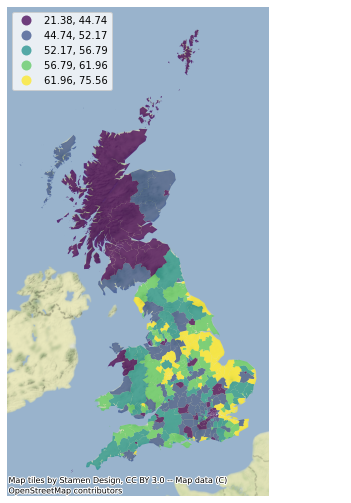

In [5]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(column='Pct_Leave', 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax
       )
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

In [6]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = 'R'

C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\pysal\lib\weights\util.py:1026: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in iterable])


In [7]:
db['Pct_Leave_lag'] = weights.spatial_lag.lag_spatial(w, db['Pct_Leave'])

In [8]:
db.loc[['E08000012', 'S12000019'], 
       ['Pct_Leave', 'Pct_Leave_lag']]

,Pct_Leave,Pct_Leave_lag
lad16cd,,
E08000012,41.81,54.61375
S12000019,37.94,38.01875


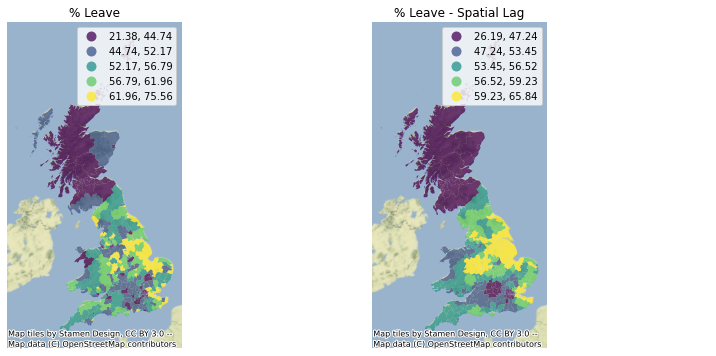

In [9]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(column='Pct_Leave', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax1)
ax1.set_axis_off()
ax1.set_title("% Leave")
contextily.add_basemap(ax1, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

db.plot(column='Pct_Leave_lag', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax2)
ax2.set_axis_off()
ax2.set_title("% Leave - Spatial Lag")
contextily.add_basemap(ax2, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

plt.show()

In [10]:
db['Leave'] = (db['Pct_Leave'] > 50).astype(int)
db[['Pct_Leave', 'Leave']].tail()

,Pct_Leave,Leave
lad16cd,,
W06000018,57.63,1
W06000019,62.03,1
W06000021,49.56,0
W06000022,55.99,1
W06000023,53.74,1


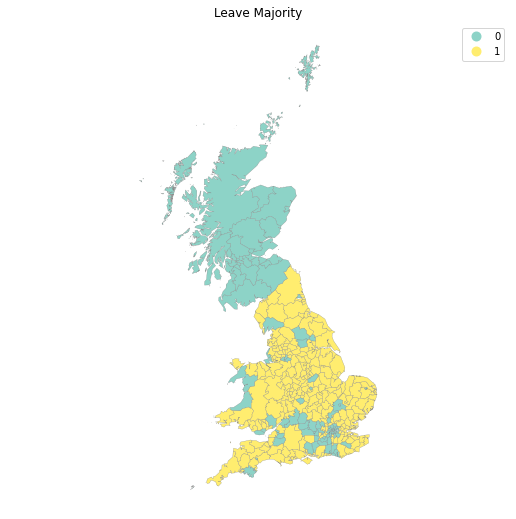

In [11]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(ax=ax, column='Leave', categorical=True, legend=True, 
        edgecolor='0.5', linewidth=0.25, cmap='Set3', 
        figsize=(9, 9));
ax.set_axis_off()
ax.set_title('Leave Majority')
plt.axis('equal')
plt.show()

In [12]:
w.transform

'R'

In [13]:
w.transform = 'O'

In [14]:
w.transform

'O'

In [15]:
seed(1234)
jc = esda.join_counts.Join_Counts(db['Leave'], w)
jc

In [16]:
jc.bb

871.0

In [17]:
jc.ww

302.0

In [18]:
jc.bw

347.0

In [19]:
jc.bb + jc.ww + jc.bw

1520.0

In [20]:
jc.J

1520.0

In [21]:
jc.mean_bb

727.4124124124124

In [22]:
jc.mean_bw

649.3233233233233

In [23]:
jc.p_sim_bb

0.001

In [24]:
jc.p_sim_bw

1.0

In [25]:
db['Pct_Leave_std'] = ( db['Pct_Leave'] - db['Pct_Leave'].mean() )
db['Pct_Leave_lag_std'] = ( db['Pct_Leave_lag'] - db['Pct_Leave_lag'].mean() )

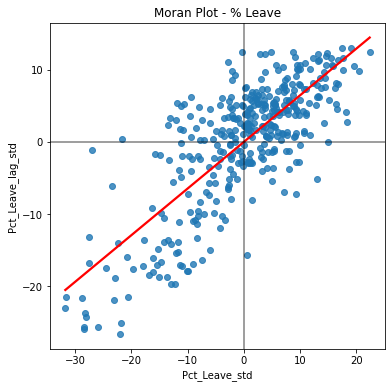

In [26]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(x='Pct_Leave_std', y='Pct_Leave_lag_std', 
                ci=None, data=db, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % Leave')
plt.show()

In [27]:
w.transform = 'R'
moran = esda.moran.Moran(db['Pct_Leave'], w)

In [28]:
moran.I

0.6454521298096587

In [29]:
moran.p_sim

0.001

AxesSubplot(0.125,0.125;0.775x0.755)


UnboundLocalError: local variable 'fig' referenced before assignment

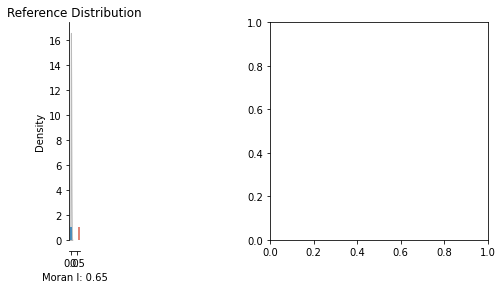

In [42]:
if ax is None:
        fig = plt.figure()
        ax = fig.gca()
        plot_moran(moran,moran.p_sim);
print(ax)
plot_moran(moran);

In [43]:
geary = esda.geary.Geary(db['Pct_Leave'], w)

In [44]:
geary.C

0.4080233215854692

In [45]:
geary.p_sim

0.001

In [46]:
db_osgb = db.to_crs(epsg=27700)
pts = db_osgb.centroid
xys = pandas.DataFrame({'X': pts.x, 'Y': pts.y})
min_thr = weights.util.min_threshold_distance(xys)
min_thr

180878.91800926058

In [47]:
w_db = weights.DistanceBand.from_dataframe(db_osgb, min_thr)

C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\pysal\lib\weights\util.py:1026: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in iterable])


In [48]:
gao = esda.getisord.G(db['Pct_Leave'], w_db)

In [49]:
print("Getis & Ord G: %.3f | Pseudo P-value: %.3f"%(gao.G, gao.p_sim))

Getis & Ord G: 0.434 | Pseudo P-value: 0.003
